# Convolutional LSTM One To One Neural Network

Implementing a Convolutional LSTM with 6 entry channels being them `[T_int, Q_heat, T_env, T_prev, mask_interfaces, mask_heaters]`, all in shape `[T, 13, 13]`. It predices the full `T` sequence of the system

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [1]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)

    return IN_COLAB, base_path, datasets_path, models_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [2]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [3]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Optimización
import optuna

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))

# Módulos propios del proyecto
from architectures.convlstm import *
from Dataset_Class_convlstm import *
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [4]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cuda



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [5]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.19041',
 'machine': 'AMD64',
 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel',
 'python_version': '3.9.21',
 'device': 'cuda',
 'gpu_name': 'NVIDIA GeForce GTX 1050',
 'gpu_memory_total_GB': 2.0,
 'cuda_version': '11.8'}


Ajusta parámetros visuales para gráficos con matplotlib y seaborn, activando cuadrícula, tamaños de fuente adecuados y un estilo profesional para las figuras.

In [6]:
configurar_graficos(True)

🎨 Estilo gráfico configurado con fondo blanco y paleta 'colorblind'.


### Hyperparameters and data features

Define los hiperparámetros principales del experimento:

- Número de muestras para entrenamiento, validación y test.
- Duración de la simulación en segundos (`time_sim`) y su resolución temporal (`dt`).
- Tamaño del batch (`batch_size`), temperatura inicial (no cambiar el valor por defecto) y número de nodos por lado del PCB.
- La longitud de la secuencia temporal de salida se define como `time_sim + 1`.

Este bloque establece los parámetros que controlan cómo se estructuran los datos y la simulación.

In [ ]:
# ⚙️ Parámetros del conjunto de datos
n_train = 2500    # Número de muestras para entrenamiento
n_val = 200       # Número de muestras para validación
n_test = 20       # Número de muestras para test

# ⏱️ Parámetros temporales
time_sim = 20    # Duración total de la simulación (s)
dt = 1            # Paso de tiempo (s)
sequence_length = time_sim + 1  # Longitud de la secuencia temporal (incluye t=0)
input_channels = 6

# 🔥 Condiciones físicas
T_init = 298.0    # Temperatura inicial (K)
nodes_side = 13   # Número de nodos por lado en la malla del PCB (13x13)

# 📦 Batch
batch_size = 256  # Tamaño del batch


Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [ ]:
# ⚙️ Hiperparámetros de entrenamiento
epochs = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50

# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

In [9]:
# Hiper-parámetros de scheduled sampling
p0              = 1.0            # probabilidad inicial de usar GT
p_min           = 0.0            # probabilidad final de usar GT
decay_epochs    = epochs // 5    # en cuántas épocas bajar de p0 a p_min

## Non-physics ConvLSTM

### Dataset import

Carga los datasets de entrenamiento, validación y test desde disco usando funciones personalizadas (`load_dataset_convlstm` y `load_trimmed_dataset_convlstm`), que también preparan los datos para ser usados por PyTorch.

Después, crea los `DataLoader` para cada conjunto de datos:

- `train_loader`: con `shuffle=True` para entrenamiento.
- `val_loader` y `test_loader`: sin barajar, para validación y prueba.

Estos objetos permiten iterar sobre los datos por batches durante el entrenamiento y evaluación.


In [10]:
# if IN_COLAB:
#   dir_path = BASE_PATH

dataset = load_dataset_convlstm(base_path=BASE_PATH)

dataset_train = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True)
dataset_val = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True)
dataset_test = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

✅ Cargando ConvLSTM transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:413: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_path)


📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_test.pth
📦 Dataset movido a: CUDA


Muestra las dimensiones del primer batch de entrada (`x_batch`) y de salida (`y_batch`) provenientes del `train_loader`.

Esto es útil para verificar que los datos han sido cargados correctamente y tienen las dimensiones esperadas.

Se detiene tras el primer batch usando `break`.


In [11]:
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break  # Solo muestra el primer batch

x_batch shape: torch.Size([256, 21, 6, 13, 13])
y_batch shape: torch.Size([256, 21, 1, 13, 13])


Extrae un batch del `train_loader`, selecciona la última imagen temporal del primer ejemplo y la muestra usando un mapa de calor (`imshow` con `cmap='hot'`).

Esto permite visualizar la distribución de temperatura final en el tiempo para ese ejemplo específico.

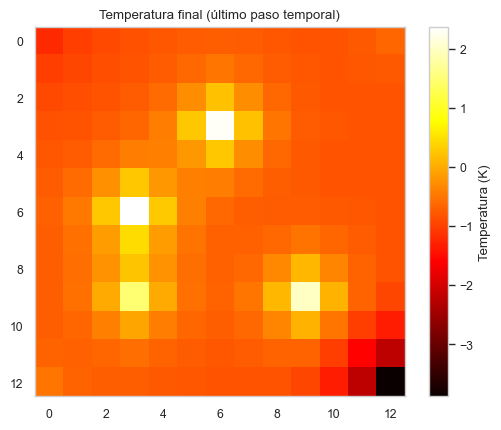

In [12]:
# Obtener primer batch
x_batch, _ = next(iter(train_loader))

# Seleccionar el último mapa de temperatura del primer ejemplo
x_tfinal = x_batch[0, -1, -1]  # Shape: (C, H, W) -> (-1) para último paso temporal

# Mostrar el mapa térmico
plt.imshow(x_tfinal.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title("Temperatura final (último paso temporal)")
plt.colorbar(label="Temperatura (K)")
plt.grid(False)
plt.show()


### Hyperparameters

Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [13]:
# ⚙️ Hiperparámetros de entrenamiento
epochs = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50

# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

### Model definition

Define la clase `PCB_ConvLSTM`, una red neuronal basada en ConvLSTM para predecir la evolución térmica en un PCB.

- Usa `ConvLSTM` como núcleo para modelar la secuencia temporal.
- Incluye una capa `Conv2d` de 1x1 al final para proyectar la salida oculta a un canal de temperatura.
- El método `forward` procesa secuencias completas (`seq_len > 1`), mientras que `forward_step` permite avanzar un paso en modo autoregresivo.

Esta arquitectura es adecuada para secuencias espacio-temporales de mapas térmicos.


In [14]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=input_channels, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden

Instancia el modelo `PCB_ConvLSTM` y lo envía al dispositivo adecuado (`cpu` o `cuda`).

Se define:

- `criterion`: función de pérdida MSE.
- `optimizer`: Adam con la tasa de aprendizaje definida previamente.
- `scheduler`: ReduceLROnPlateau para ajustar el `lr` si la pérdida se estanca.

In [140]:
# Inicializar el modelo
model = PCB_ConvLSTM(
    input_channels=input_channels,
    hidden_dims=hidden_dims,
    kernel_size=kernel_size
).to(device)

# Pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Mostrar información básica del modelo
print(f"Modelo en dispositivo: {device}")
print(f"Parámetros totales: {num_params:,}")

Modelo en dispositivo: cuda
Parámetros totales: 456,769


### Entrenamiento del modelo


Define los hiperparámetros para el *scheduled sampling*, una técnica para entrenamiento autoregresivo:

- `p0`: probabilidad inicial de usar el valor real (ground truth).
- `p_min`: probabilidad mínima de usar GT al final del entrenamiento.
- `decay_epochs`: número de épocas en las que se reducirá `p0` hasta `p_min`.

Esta técnica ayuda a la red a adaptarse gradualmente a predecir sin necesidad del ground truth.


In [16]:
# # Hiper-parámetros de scheduled sampling
# p0              = 1.0            # probabilidad inicial de usar GT
# p_min           = 0.0            # probabilidad final de usar GT
# decay_epochs    = epochs // 5    # en cuántas épocas bajar de p0 a p_min

Inicializa las variables de entrenamiento y prepara el sistema para **reanudar una sesión previa** si existe:

- Crea la carpeta de salida.
- Construye el nombre del fichero de modelo según los hiperparámetros.
- Si encuentra un modelo `.pth` guardado, lo carga junto con su configuración `.json`.
- Si no hay modelo previo, inicia un nuevo entrenamiento desde cero.

Esta lógica permite continuar el entrenamiento sin perder el progreso.


In [17]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

# ----------- Inicialización de estado -----------
train_loss = []
val_loss = []
best_val_loss = np.inf
elapsed_previous = 0.0
start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
epochs_without_improvement = 0

# ----------- Lógica de reanudación -----------
if model_path.exists():
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))

    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                prev = json.load(f)
            best_val_loss = prev.get('best_val_loss', best_val_loss)
            train_loss = prev.get('train_loss', [])
            val_loss = prev.get('val_loss', [])
            elapsed_previous = prev.get('training_duration_minutes', 0.0)
            start_datetime = prev.get('start_datetime', start_datetime)
            start_epoch = prev.get('epochs_trained', 0)
            epochs_without_improvement = 0
        except json.JSONDecodeError:
            print(f"⚠️ El archivo {json_path} está vacío o corrupto. Se reinician los contadores.")
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)


🔁 Cargando modelo existente `PCB_ConvLSTM_6ch_nt2500_20s_bs256_h64-64_k3x3.pth` y reanudando entrenamiento.

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O\PCB_ConvLSTM_6ch_nt2500_20s_bs256_h64-64_k3x3.json


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\2534762150.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

Define el **bucle de entrenamiento completo** para la red `PCB_ConvLSTM`, incluyendo:

- Entrenamiento paso a paso con *scheduled sampling* autoregresivo.
- Validación del modelo tras cada época.
- Ajuste automático de la tasa de aprendizaje con `ReduceLROnPlateau`.
- Early stopping si no hay mejora tras cierto número de épocas.
- Guardado del mejor modelo y de los resultados en un archivo `.json`.

El entrenamiento es completamente reproducible y robusto frente a interrupciones.


In [ ]:
# 1) Desactivar CUDAGraphs globalmente (antes de importar torch._inductor)
os.environ["TORCHINDUCTOR_DISABLE_CUDAGRAPHS"] = "1"

# 2) Imports y configuración
# import json
# import time
# import torch
# import torch._dynamo
# from torch import amp
# from tqdm import tqdm
# from contextlib import nullcontext

# Si torch.compile lanza errores, cae a modo eager
torch._dynamo.config.suppress_errors = True

def entrenar_modelo_cuda(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        model_path, json_path,
        epochs, early_stop_patience,
        p0=1.0, p_min=0.0, decay_epochs=50,
        device=None, start_epoch=0,
        train_loss=None, val_loss=None,
        best_val_loss=float('inf'),
        elapsed_previous=0.0,
        start_datetime=None,
        system_specs=None,
        amp_enabled=True,   # mixtura de precisión
        clip_grad=None,
        use_compile=True):  # activar torch.compile

    # Preparación
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = model.to(device)

    # torch.compile con mode reduce-overhead (CUDAGraphs ya desactivado via env var)
    if use_compile and torch.__version__ >= '2' and device.type == 'cuda':
        props = torch.cuda.get_device_properties(device)
        if props.major >= 7:
            model = torch.compile(model, mode="reduce-overhead")
            print("Modelo compilado (CUDAGraphs desactivado).")
        else:
            print(f"torch.compile desactivado: CC {props.major}.{props.minor} < 7.0")

    torch.backends.cudnn.benchmark = True

    # AMP: GradScaler y autocast (API torch.amp)
    scaler = amp.GradScaler(enabled=amp_enabled)
    if amp_enabled:
        # Usaremos autocast de CUDA sólo cuando amp_enabled=True
        autocast_ctx = lambda: torch.cuda.amp.autocast(enabled=True)
    else:
        # Contexto vacío si AMP desactivado
        autocast_ctx = nullcontext

    # Inicializar listas y tiempos
    train_loss = [] if train_loss is None else train_loss
    val_loss   = [] if val_loss   is None else val_loss
    start_datetime = start_datetime or time.strftime("%Y-%m-%d %H:%M:%S")
    start_time_training = time.time() - elapsed_previous*60
    epochs_without_improvement = 0

    # Bucle de epochs
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0.0
        p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

        for x_batch, y_batch in tqdm(train_loader,
                                     desc=f"Epoch {epoch+1}/{epochs}",
                                     leave=False):
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            _, T, _, _, _ = x_batch.shape

            bc_seq, t_prev = x_batch[:, :, :5], x_batch[:, 0, 5:6]
            hidden, loss_accum = None, 0.0

            optimizer.zero_grad(set_to_none=True)
            with autocast_ctx():
                for t in range(T):
                    if t == 0:
                        t_in = t_prev
                    else:
                        mask = (torch.rand_like(t_prev) < p_gt).float()
                        t_in = mask * y_batch[:, t-1] + (1-mask) * t_prev.detach()

                    x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                    pred_seq, hidden = model(x_t, hidden)
                    t_prev = pred_seq[:, 0]
                    loss_accum += criterion(t_prev, y_batch[:, t])

                loss_batch = loss_accum / T

            scaler.scale(loss_batch).backward()
            if clip_grad:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss_batch.item()

        train_loss.append(total_loss/len(train_loader))

        # Validación
        epoch_val_loss = _validacion(model, val_loader, criterion, device)
        val_loss.append(epoch_val_loss)

        # Scheduler & Early stopping
        scheduler.step(epoch_val_loss)
        lr = optimizer.param_groups[0]['lr']
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}")
                break

        # Guardar parametros en JSON
        _guardar_json(json_path, {
            'start_datetime': start_datetime,
            'training_duration_minutes': (time.time()-start_time_training)/60,
            'model_parameters': num_params,            
            'system_specs': system_specs,
            'hidden_dims': list(model.convlstm.hidden_dim),
            'kernel_size': model.convlstm.kernel_size[0],
            'batch_size': train_loader.batch_size,
            'lr': lr,
            'scheduler': {
                'type':'ReduceLROnPlateau',
                'factor':scheduler.factor,
                'patience':scheduler.patience,
                'final_lr':lr
            },
            'early_stop_patience':early_stop_patience,
            'epochs_trained':epoch+1,
            'best_val_loss':best_val_loss,
            'train_loss':train_loss,
            'val_loss':val_loss
        })

    print(f"Entrenamiento finalizado en {(time.time()-start_time_training)/60:.2f} min")
    return train_loss, val_loss, best_val_loss

# Funciones auxiliares
def _validacion(model, val_loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device, non_blocking=True)
            y_val = y_val.to(device, non_blocking=True)
            _, T, _, _, _ = x_val.shape
            bc_seq, t_prev = x_val[:, :, :5], x_val[:, 0, 5:6]
            hidden, loss_accum = None, 0.0
            for t in range(T):
                x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                loss_accum += criterion(t_prev, y_val[:, t])
            total += (loss_accum/T).item()
    return total/len(val_loader)

def _guardar_json(ruta, params):
    with open(ruta, 'w') as f:
        json.dump(params, f, indent=4)



# Auxiliares

def _validacion(model, val_loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device, non_blocking=True)
            y_val = y_val.to(device, non_blocking=True)
            _, T, _, _, _ = x_val.shape

            bc_seq, t_prev = x_val[:, :, :5], x_val[:, 0, 5:6]
            hidden, loss_accum = None, 0.0

            for t in range(T):
                x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                loss_accum += criterion(t_prev, y_val[:, t])

            total += (loss_accum / T).item()
    return total / len(val_loader)

def _guardar_json(ruta, params):
    with open(ruta, 'w') as f:
        json.dump(params, f, indent=4)

In [ ]:
train_loss, val_loss, best_val = entrenar_modelo_cuda(
    model,                 # tu modelo ConvLSTM
    train_loader,          # DataLoader con pin_memory=True, num_workers>0
    val_loader,
    criterion,
    optimizer,
    scheduler,
    model_path,
    json_path,
    epochs,
    early_stop_patience,
    start_epoch=start_epoch,
    train_loss=train_loss,
    val_loss=val_loss,
    best_val_loss=best_val_loss,
    elapsed_previous=elapsed_previous,
    start_datetime=start_datetime,
    # Parámetros de scheduled sampling (igual que antes)
    p0=1.0,
    p_min=0.0,
    decay_epochs=decay_epochs,
    # Omite "device" si quieres auto-detección de GPU
    amp_enabled=True,      # FP16 con la API torch.amp
    clip_grad=None,        # clipping opcional
    use_compile=False       # Desactiva torch.compile para probar
)

Entrenamiento finalizado en 26.56 min


Grafica la evolución de las pérdidas (`train_loss` y `val_loss`) a lo largo del entrenamiento.

Esto permite analizar visualmente el comportamiento del modelo, detectar sobreajuste o problemas de convergencia.


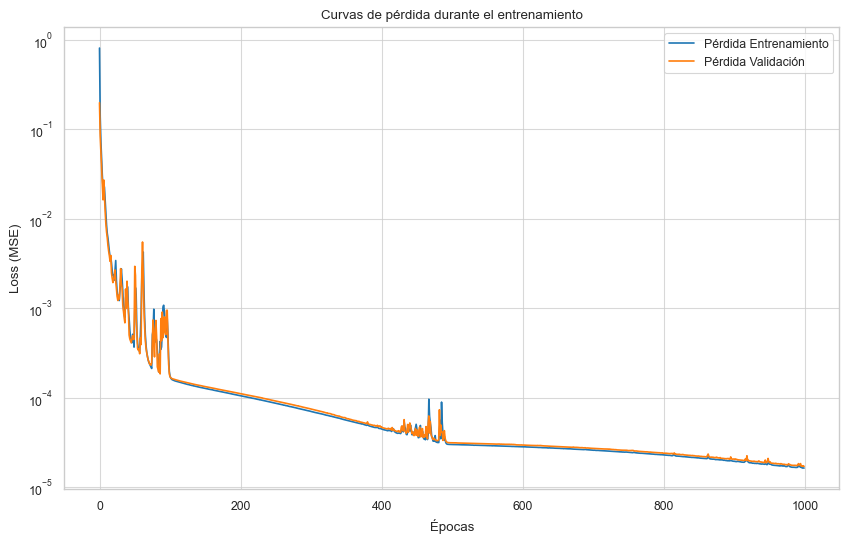

In [ ]:
plot_loss_curves(train_loss, val_loss, save_as_pdf=False, filename='loss_curves')

### Testing

Carga el mejor modelo entrenado y evalúa su rendimiento en el conjunto de test mediante una función `rollout` autoregresiva.

- La función `rollout` genera toda la secuencia de salida autoregresiva usando como entrada las condiciones de contorno (`bc_seq`) y la temperatura inicial (`T0`).
- Se evalúa la pérdida total del modelo sobre todas las muestras y también se calcula la pérdida por paso de tiempo.

Incluye impresión opcional de errores en pasos específicos para analizar cómo evoluciona el error en el tiempo.


In [21]:
# --- 1. Carga del mejor modelo ---
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- 2. Función de rollout autoregresivo puro ---
@torch.no_grad()
def rollout(model, bc_seq, T0):
    """
    Predicción autoregresiva completa.

    Args:
        model   : modelo PyTorch
        bc_seq  : tensor (B, T, 5, H, W) con canales de contorno ya en device
        T0      : tensor (B, 1, H, W) condición inicial ya en device

    Returns:
        preds   : tensor (B, T, 1, H, W) con predicciones autoregresivas
    """
    B, T, _, H, W = bc_seq.shape
    preds = []
    t_prev = T0
    hidden = None

    for t in range(T):
        x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)  # (B,1,6,H,W)
        pred_seq, hidden = model(x_t, hidden)
        t_prev = pred_seq[:, 0]
        preds.append(t_prev)

    return torch.stack(preds, dim=1)

# --- Test completo ---
test_losses = []
step_losses = torch.zeros(sequence_length, device=device)

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        bc_seq = x_batch[:, :, :5]
        T0 = x_batch[:, 0, 5:6]

        y_pred = rollout(model, bc_seq, T0)

        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        for t in range(y_pred.shape[1]):
            step_losses[t] += criterion(y_pred[:, t], y_batch[:, t]).item() * y_pred.size(0)

mean_test_loss = sum(test_losses) / len(test_losses)
step_losses = (step_losses / len(test_loader.dataset)).cpu().numpy()

print(f"▶︎ Test Loss (secuencia completa): {mean_test_loss:.6f}")

for t_idx in [0, y_pred.shape[1]-1]:
    print(f"  Paso {t_idx+1:2d} Loss: {step_losses[t_idx]:.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\3399994624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

▶︎ Test Loss (secuencia completa): 0.000019
  Paso  1 Loss: 0.000010
  Paso 21 Loss: 0.000058


### Analyzing results

In [154]:
# time_sim = 50
# sequence_length = time_sim + 1

Define una función `predict_from_conditions(...)` que genera una predicción completa de temperatura dada una condición inicial y parámetros físicos del sistema (como temperaturas de interfaces y potencia de calentadores).

- Usa el método `create_input_from_values` del dataset para construir la entrada a partir de arrays.
- Realiza el `rollout` paso a paso utilizando el método `forward_step` del modelo.
- Devuelve una secuencia completa desnormalizada en formato `np.ndarray`.

Esta función es clave para usar el modelo en modo inferencia realista, fuera del flujo de entrenamiento.


In [155]:
# def predict_from_conditions(Q_heaters: np.ndarray,
#                             T_interfaces: np.ndarray,
#                             T_env: float,
#                             sequence_length: int = 1001,
#                             T_seq_initial: np.ndarray = None,
#                             model=None,
#                             dataset=None,
#                             device=None) -> np.ndarray:
#     """
#     Genera una predicción completa de long. sequence_length a partir de:
#       - Q_heaters:        (4,)             np.ndarray
#       - T_interfaces:     (4,)             np.ndarray
#       - T_env:            scalar           float
#       - T_seq_initial:    (13,13)          np.ndarray (el mapa inicial)
#       - sequence_length:  número de pasos a predecir
#       - model:            tu PCB_ConvLSTM cargado y en .eval()
#       - dataset:          instancia de PCBDataset_convlstm con create_input_from_values
#       - device:           opcional, torch.device

#     Devuelve:
#       np.ndarray de forma (sequence_length, 13, 13) con la serie desnormalizada.
#     """

#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device
        
#     if T_seq_initial is None:
#         T_seq_initial = np.full((13, 13), 298.0)  # Mapa por defecto a 298 K

#     # 1) Primer input (1,1,6,13,13)
#     input0 = dataset.create_input_from_values(
#         Q_heaters, T_interfaces, T_env,
#         T_seq=np.expand_dims(T_seq_initial, 0),
#         sequence_length=sequence_length,
#         autorregress=True
#     ).to(device)

#     # 2) Prepara contornos y t_prev
#     # bc_static: (1, seq_len, 5, 13,13)
#     bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
#     # t_prev: (1,1,1,13,13)
#     t_prev = input0[:, :1, 5:6, :, :]

#     # 3) Roll-out autoregresivo
#     preds_norm = []
#     hidden = None
#     with torch.no_grad():
#         for t in range(sequence_length):
#             # concatenar por canal (dim=2)
#             x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
#             pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
#             t_prev = pred_t                                        # mantener shape
#             preds_norm.append(t_prev)

#     preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

#     # 4) Desnormalizar y to numpy
#     mean = dataset.T_outputs_mean.to(device)
#     std  = dataset.T_outputs_std.to(device)
#     preds_denorm = preds_norm * std + mean      # (1, T, 1, H, W)
#     preds_denorm = preds_denorm.squeeze(0).squeeze(1)  # (T, 13,13)
#     return preds_denorm.cpu().numpy()

Carga de nuevo el modelo desde el disco y lo pone en modo evaluación (`eval()`), para realizar predicciones sin modificar sus parámetros.

Esto es útil para preparar el modelo antes de realizar inferencias como las de la función anterior.


In [156]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\2658188333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(70, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

Define las posiciones de los nodos que se quieran estudiar, en el caso por defecto los heaters (`id_heaters`), como tuplas de coordenadas dentro de la malla 13x13.

In [157]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Define las condiciones físicas para el caso de prueba:

- `Q_heaters`: potencia aplicada por cada calentador.
- `T_interfaces`: temperaturas fijas en las interfaces térmicas.
- `T_env`: temperatura ambiente.
- `T_initial_map`: mapa de temperatura inicial uniforme, basado en `T_init`.

Estas variables se usarán como entrada en la simulación o para el modelo entrenado.


In [158]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 280
T_initial_map = np.full((13, 13), T_init)

Ejecuta el caso de simulación real `PCB_case_2` con los parámetros definidos (en modo transitorio) para obtener la solución de referencia.

- `T`: contiene toda la evolución temporal.
- Se reestructura la salida en forma de malla `(T, 13, 13)`.
- Se convierte a `tensor` y se sube al dispositivo (`cpu` o `cuda`) para usarla en comparación o inferencia.

Esto proporciona la verdad de terreno contra la cual se comparará la predicción del modelo.


In [159]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)

Llama a la función `predict_from_conditions(...)` usando las condiciones definidas (`Q_heaters`, `T_interfaces`, `T_env`, `T_initial_map`) y genera la predicción de temperatura a lo largo del tiempo.

- Devuelve un array `(T, 13, 13)` con la evolución térmica.
- Se convierte a tensor y se envía al dispositivo para facilitar cálculos posteriores.

Este bloque representa el uso final del modelo entrenado para hacer una predicción completa.


In [160]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model,
    dataset=dataset,  # Usar el dataset de entrenamiento para crear inputs
    device=device
)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W)

print(T_pred.shape)  # (T, 13, 13)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])
(21, 13, 13)


Dibuja la evolución térmica en nodos seleccionados a lo largo del tiempo, comparando la **predicción del modelo (`T_pred`)** con la **solución de referencia (`T_true`)**.

El parámetro `together=True` indica que ambas curvas se mostrarán en la misma figura para facilitar la comparación.

Este paso permite evaluar visualmente la precisión del modelo.


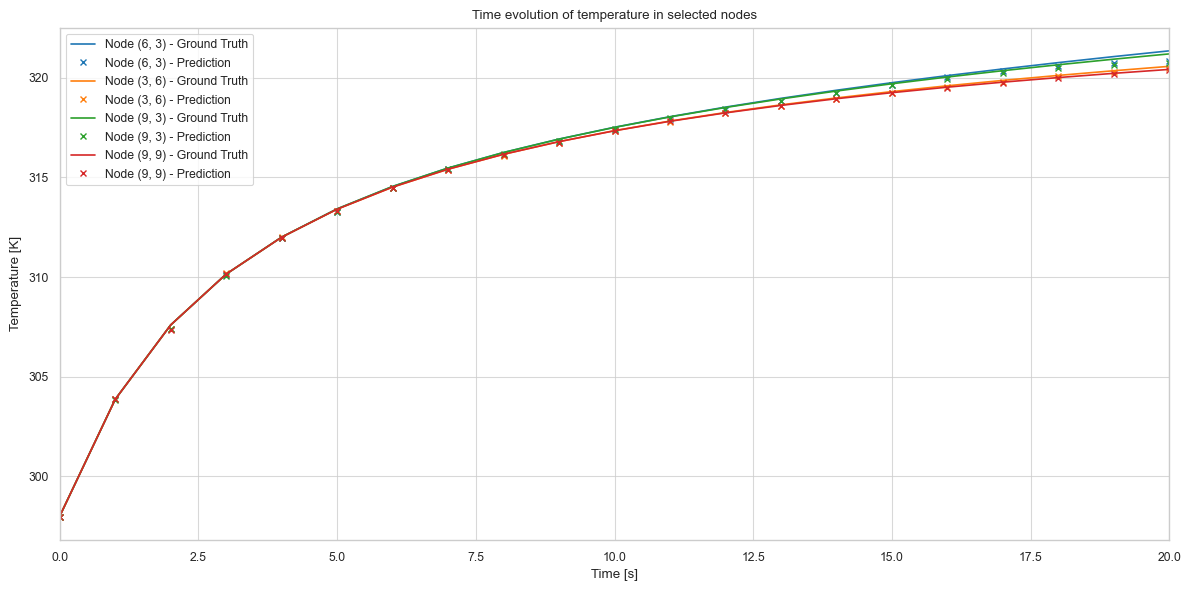

In [ ]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True, save_as_pdf=True, filename='nodes_evolution')

Evalúa la precisión del modelo usando métricas basadas en un **umbral de error absoluto** (en Kelvin):

- `porcentaje_error_bajo_umbral`: calcula el porcentaje de valores predichos cuyo error es menor que el umbral especificado.
- `nodos_siempre_dentro_umbral`: determina el porcentaje de nodos que están por debajo del umbral en **todos los pasos de tiempo**.

Estas métricas permiten cuantificar de forma robusta la calidad de la predicción.


In [165]:
umbral = 0.5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 0.5 K: 99.97%
Porcentaje de nodos buenos: 99.41%


Calcula y visualiza una **curva de precisión acumulada** en función del umbral de error:

- Evalúa qué porcentaje de nodos cumplen con el criterio de error para cada valor de umbral entre 0 y 25 K.
- Muestra una gráfica que permite analizar la sensibilidad del modelo al nivel de tolerancia de error.

Esta representación es útil para comparar distintos modelos o configuraciones.


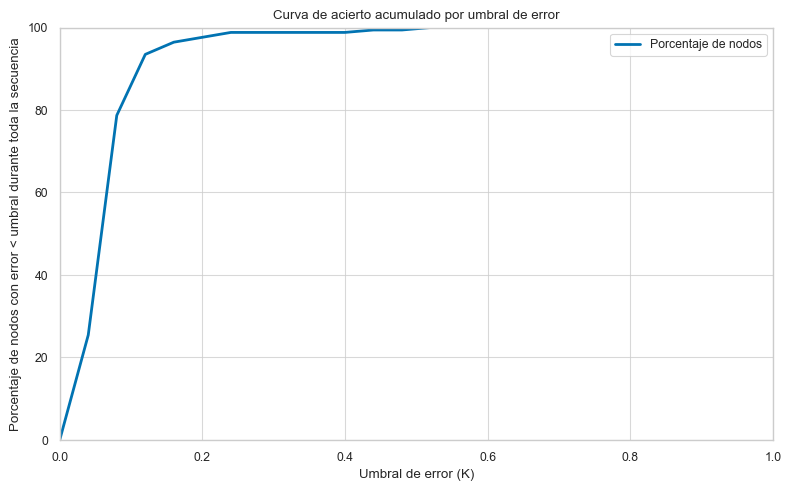

In [163]:
umbrales = np.linspace(0, 1, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Grafica el **error absoluto medio (MAE)** por fotograma (paso temporal), comparando la predicción del modelo y la solución de referencia.

Esto permite observar cómo evoluciona el error del modelo a lo largo de la secuencia y detectar posibles derivas o acumulaciones de error en el tiempo.


In [164]:
plot_mae_per_frame(T_pred, T_true, dataset, save_as_pdf=True, filename='mae_per_frame')

TypeError: plot_mae_per_frame() got an unexpected keyword argument 'save_as_pdf'

Genera una figura con el **MAE por píxel** (nodo de la malla), calculado sobre toda la secuencia temporal.

Esto permite identificar qué zonas del PCB tienen mayor o menor error sistemático, y si existen patrones espaciales en el comportamiento del modelo.


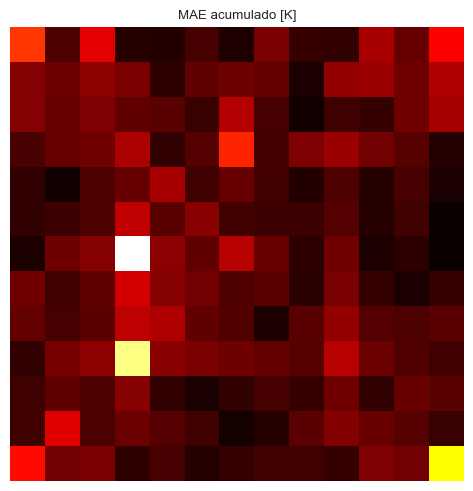

In [ ]:
plot_mae_per_pixel(T_pred, T_true, dataset, save_as_pdf=True, filename='mae_per_pixel')

Crea una animación en forma de **GIF comparativo** entre la predicción (`T_pred`) y la solución real (`T_true`) a lo largo del tiempo.

- Guarda el GIF en la carpeta `figures`.
- Lo muestra directamente en el notebook usando HTML.

Esta animación es muy útil para validar visualmente el desempeño dinámico del modelo.


In [ ]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='comparacion')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Genera un **GIF que visualiza la evolución del error absoluto** entre la predicción y la realidad en cada paso temporal.

- Muestra cómo cambia el error con el tiempo.
- Útil para detectar acumulación de error, deriva o zonas problemáticas.

La animación se guarda y se muestra directamente en el notebook.


In [ ]:
ani = generar_gif_error_evolucion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='error')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

## Phisics informed ConvLSTM

### Dataset import

Define los hiperparámetros principales del experimento:

- Número de muestras para entrenamiento, validación y test.
- Duración de la simulación en segundos (`time_sim`) y su resolución temporal (`dt`).
- Tamaño del batch (`batch_size`), temperatura inicial (no cambiar el valor por defecto) y número de nodos por lado del PCB.
- La longitud de la secuencia temporal de salida se define como `time_sim + 1`.

Este bloque establece los parámetros que controlan cómo se estructuran los datos y la simulación.

In [40]:
# # ⚙️ Parámetros del conjunto de datos
# n_train = 10    # Número de muestras para entrenamiento
# n_val = 200       # Número de muestras para validación
# n_test = 20       # Número de muestras para test

# # ⏱️ Parámetros temporales
# time_sim = 10    # Duración total de la simulación (s)
# dt = 1            # Paso de tiempo (s)
# sequence_length = time_sim + 1  # Longitud de la secuencia temporal (incluye t=0)

# # 🔥 Condiciones físicas
# T_init = 298.0    # Temperatura inicial (K)
# nodes_side = 13   # Número de nodos por lado en la malla del PCB (13x13)

# # 📦 Batch
# batch_size = 128  # Tamaño del batch

Carga los datasets de entrenamiento, validación y test desde disco usando funciones personalizadas (`load_dataset_convlstm` y `load_trimmed_dataset_convlstm`), que también preparan los datos para ser usados por PyTorch.

Después, crea los `DataLoader` para cada conjunto de datos:

- `train_loader`: con `shuffle=True` para entrenamiento.
- `val_loader` y `test_loader`: sin barajar, para validación y prueba.

Estos objetos permiten iterar sobre los datos por batches durante el entrenamiento y evaluación.


In [41]:
# if IN_COLAB:
#   dir_path = BASE_PATH

dataset_phy = load_dataset_convlstm(base_path=BASE_PATH, physic=True)

dataset_train_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True, physic=True)
dataset_val_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True, physic=True)
dataset_test_phy = load_trimmed_dataset_convlstm(base_path=BASE_PATH, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True, physic=True)

train_loader_phy = DataLoader(dataset_train_phy, batch_size=batch_size, shuffle=True)
val_loader_phy = DataLoader(dataset_val_phy, batch_size=batch_size, shuffle=False)
test_loader_phy = DataLoader(dataset_test_phy, batch_size=batch_size, shuffle=False)

✅ Cargando ConvLSTM transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_phy_6ch_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_phy_6ch_transient_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:413: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_path)


📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_phy_6ch_transient_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_phy_6ch_transient_dataset_test.pth
📦 Dataset movido a: CUDA


Muestra las dimensiones del primer batch de entrada (`x_batch`) y de salida (`y_batch`) provenientes del `train_loader`.

Esto es útil para verificar que los datos han sido cargados correctamente y tienen las dimensiones esperadas.

Se detiene tras el primer batch usando `break`.


In [42]:
for x1, x2, x3, x4, x5 in train_loader_phy:
    print("x1 shape:", x1.shape)
    print("x2 shape:", x2.shape)
    print("x3 shape:", x3.shape)
    print("x4 shape:", x4.shape)
    print("x5 shape:", x5.shape)
    break  # Solo muestra el primer batch

x1 shape: torch.Size([256, 21, 6, 13, 13])
x2 shape: torch.Size([256, 21, 1, 13, 13])
x3 shape: torch.Size([256, 4])
x4 shape: torch.Size([256, 4])
x5 shape: torch.Size([256, 1])


Extrae un batch del `train_loader`, selecciona la última imagen temporal del primer ejemplo y la muestra usando un mapa de calor (`imshow` con `cmap='hot'`).

Esto permite visualizar la distribución de temperatura final en el tiempo para ese ejemplo específico.

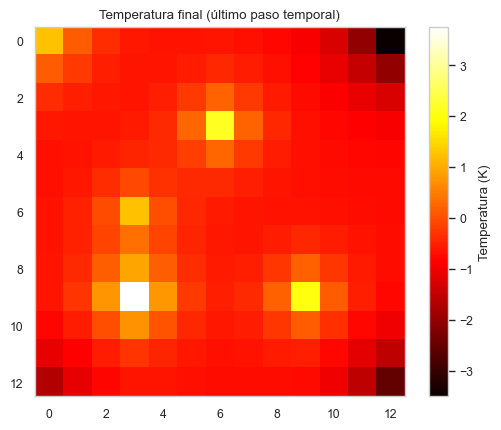

In [43]:
# Obtener primer batch
x_batch, *_ = next(iter(train_loader_phy))

# Seleccionar el último mapa de temperatura del primer ejemplo
x_tfinal = x_batch[0, -1, -1]  # Shape: (C, H, W) -> (-1) para último paso temporal

# Mostrar el mapa térmico
plt.imshow(x_tfinal.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title("Temperatura final (último paso temporal)")
plt.colorbar(label="Temperatura (K)")
plt.grid(False)
plt.show()


### Loss function

Weight for the parameters in the loss funcion

**INCLUIR LA EXPRESIÓN DE LA FUNCIÓN DE PÉRDIDA**

In [44]:
mse_weight = 1e0
physics_weight = 1e-1
boundary_weight = 1e-3

Implementación de la función de pérdida para ver su eficiencia con los datos del solver

In [45]:
# 1) Instancia las pérdidas
physics_loss_fn  = PhysicsLossTransient().to(device)
boundary_loss_fn = BoundaryLoss(nx=13, ny=13, device=device).to(device)

# 2) Toma un batch “ground-truth”
x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch = next(iter(train_loader_phy))
# Shapes:
#   x_batch:      (B, T, 6, 13, 13)
#   y_batch_norm: (B, T, 1, 13, 13)
#   Q_batch:      (B, 4)
#   Ti_batch:     (B, 4)
#   Tenv_batch:   (B, 1)

# 3) Desnormaliza y_batch para pasar a físicas
#    dataset_phy.denormalize_output espera (..., H, W)
y_denorm = dataset_phy.denormalize_output(
    y_batch_norm.squeeze(2)    # (B, T, 13, 13)
).unsqueeze(2).to(device)      # (B, T, 1, 13, 13)

# 4) Calcula las pérdidas
loss_phys = physics_loss_fn(
    y_denorm,                   # pred = true
    y_denorm,                   # true = true
    Q_batch.to(device),         # (B, 4)
    Ti_batch.to(device),        # (B, 4)
    Tenv_batch.to(device)       # (B, 1)
)

loss_bdry = boundary_loss_fn(
    y_denorm,                   # (B, T, 1, 13, 13)
    Ti_batch.to(device)         # (B, 4)
)

# 5) Prueba TotalLoss sobre ground-truth
total_loss_fn = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=physics_weight,
    boundary_weight=boundary_weight,
    denormalize_output_fn=dataset_phy.denormalize_output
).to(device)

total_loss, mse_loss, phys_loss, bdry_loss = total_loss_fn(
    y_batch_norm, y_batch_norm, Q_batch.to(device), Ti_batch.to(device), Tenv_batch.to(device)
)

print(f"TotalLoss on ground-truth batch: {total_loss.item():.3e}")
print(f"  MSE:      {mse_loss.item():.3e}")
print(f"  Physics:  {phys_loss.item():.3e}")
print(f"  Boundary: {bdry_loss.item():.3e}")

assert total_loss.item() < 1e-6, "¡TotalLoss no cero sobre ground-truth!"

# print(f"PhysicsLoss on ground-truth batch: {loss_phys.item():.3e}")
# print(f"BoundaryLoss on ground-truth batch: {loss_bdry.item():.3e}")

# Opcionalmente, assert para asegurar que sean ~0
assert loss_phys.item()  < 1e-6, "¡Pérdida física no cero sobre ground-truth!"
assert loss_bdry.item() < 1e-6, "¡Pérdida de frontera no cero sobre ground-truth!"


TotalLoss on ground-truth batch: 2.536e-13
  MSE:      0.000e+00
  Physics:  2.536e-12
  Boundary: 0.000e+00


c:\Users\ismael.gallo\Desktop\ia_thermal\Physics_Loss.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


### Hyperparameters

Define los hiperparámetros del entrenamiento:

- Número de épocas (`epochs`)
- Tasa de aprendizaje inicial (`lr`) y su factor de decaimiento (`lrdecay`)
- Paciencia para reducir el `lr` (`lrdecay_patience`) y para aplicar `early stopping` (`early_stop_patience`)
- Arquitectura del modelo: número de filtros por capa en `hidden_dims` y tamaño del kernel

Estos valores controlan el comportamiento del optimizador y la estructura de la red ConvLSTM.


In [46]:
# # ⚙️ Hiperparámetros de entrenamiento
# epochs = 5
# lr = 1e-2
# lrdecay = 0.1
# lrdecay_patience = 10
# early_stop_patience = 50

# # 🧠 Arquitectura ConvLSTM
# hidden_dims = [64, 64]                     # Número de filtros por capa
# num_layers = len(hidden_dims)
# kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

### Model definition

Define la clase `PCB_ConvLSTM`, una red neuronal basada en ConvLSTM para predecir la evolución térmica en un PCB.

- Usa `ConvLSTM` como núcleo para modelar la secuencia temporal.
- Incluye una capa `Conv2d` de 1x1 al final para proyectar la salida oculta a un canal de temperatura.
- El método `forward` procesa secuencias completas (`seq_len > 1`), mientras que `forward_step` permite avanzar un paso en modo autoregresivo.

Esta arquitectura es adecuada para secuencias espacio-temporales de mapas térmicos.


In [47]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden

Instancia el modelo `PCB_ConvLSTM_phy` y lo envía al dispositivo adecuado (`cpu` o `cuda`).

Se define:

- `criterion`: función de pérdida MSE.
- `optimizer`: Adam con la tasa de aprendizaje definida previamente.
- `scheduler`: ReduceLROnPlateau para ajustar el `lr` si la pérdida se estanca.

In [138]:
# Inicializar el modelo
model_phy = PCB_ConvLSTM(
    input_channels=6,
    hidden_dims=hidden_dims,
    kernel_size=kernel_size
).to(device)

# Pérdida y optimizador
criterion_phy = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=physics_weight,
    boundary_weight=boundary_weight,
    denormalize_output_fn=dataset_phy.denormalize_output
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_phy.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

num_params = sum(p.numel() for p in model_phy.parameters() if p.requires_grad)

# Mostrar información básica del modelo
print(f"Modelo en dispositivo: {device}")
print(f"Parámetros totales: {num_params}")

Modelo en dispositivo: cuda
Parámetros totales: 456769


### Entrenamiento del modelo


Define los hiperparámetros para el *scheduled sampling*, una técnica para entrenamiento autoregresivo:

- `p0`: probabilidad inicial de usar el valor real (ground truth).
- `p_min`: probabilidad mínima de usar GT al final del entrenamiento.
- `decay_epochs`: número de épocas en las que se reducirá `p0` hasta `p_min`.

Esta técnica ayuda a la red a adaptarse gradualmente a predecir sin necesidad del ground truth.


In [49]:
# # Hiper-parámetros de scheduled sampling
# p0              = 1.0            # probabilidad inicial de usar GT
# p_min           = 0.0            # probabilidad final de usar GT
# decay_epochs    = epochs // 5    # en cuántas épocas bajar de p0 a p_min

Inicializa las variables de entrenamiento y prepara el sistema para **reanudar una sesión previa** si existe:

- Crea la carpeta de salida.
- Construye el nombre del fichero de modelo según los hiperparámetros.
- Si encuentra un modelo `.pth` guardado, lo carga junto con su configuración `.json`.
- Si no hay modelo previo, inicia un nuevo entrenamiento desde cero.

Esta lógica permite continuar el entrenamiento sin perder el progreso.


In [50]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_bs{batch_size}_h{layer_string}_k{kernel_string}_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

# ----------- Inicialización de estado -----------
train_acc = {"total": [], "mse": [], "physics": [], "boundary": []}
val_acc   = {"total": [], "mse": [], "physics": [], "boundary": []}
best_val_loss = np.inf
elapsed_previous = 0.0
start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
epochs_without_improvement = 0

# ----------- Lógica de reanudación -----------
if model_path.exists():
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model_phy.load_state_dict(torch.load(model_path, map_location=device))

    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                prev = json.load(f)
            best_val_loss = prev.get('best_val_loss', best_val_loss)
            elapsed_previous = prev.get('training_duration_minutes', 0.0)
            start_datetime = prev.get('start_datetime', start_datetime)
            start_epoch = prev.get('epochs_trained', 0)
            # Cargar correctamente las curvas completas
            if 'losses' in prev:
                train_acc = prev['losses'].get('train', train_acc)
                val_acc   = prev['losses'].get('val', val_acc)
            else:
                # Compatibilidad con versiones antiguas
                for k in train_acc:
                    train_acc[k] = prev.get(f"train_{k}_loss", [])
                    val_acc[k]   = prev.get(f"val_{k}_loss", [])
            epochs_without_improvement = 0
        except json.JSONDecodeError:
            print(f"⚠️ El archivo {json_path} está vacío o corrupto. Se reinician los contadores.")
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

🔁 Cargando modelo existente `PCB_ConvLSTM_6ch_nt2500_20s_bs256_h64-64_k3x3_mse1.0_phy0.1_bnd0.001.pth` y reanudando entrenamiento.

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O\PCB_ConvLSTM_6ch_nt2500_20s_bs256_h64-64_k3x3_mse1.0_phy0.1_bnd0.001.json


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\1420094277.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_phy.load_state_dict(torch.load(model_path, map_

Define el **bucle de entrenamiento completo** para la red `PCB_ConvLSTM`, incluyendo:

- Entrenamiento paso a paso con *scheduled sampling* autoregresivo.
- Validación del modelo tras cada época.
- Ajuste automático de la tasa de aprendizaje con `ReduceLROnPlateau`.
- Early stopping si no hay mejora tras cierto número de épocas.
- Guardado del mejor modelo y de los resultados en un archivo `.json`.

El entrenamiento es completamente reproducible y robusto frente a interrupciones.


In [ ]:
# 1) Desactivar CUDAGraphs globalmente (antes de importar torch._inductor)
import os
os.environ["TORCHINDUCTOR_DISABLE_CUDAGRAPHS"] = "1"

# 2) Imports y configuración
import time
import json
import torch
import torch._dynamo
from torch import amp
from tqdm import tqdm
from contextlib import nullcontext

# Si torch.compile lanza errores, cae a modo eager
torch._dynamo.config.suppress_errors = True

def entrenar_modelo_cuda_phy(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        model_path, json_path,
        epochs, early_stop_patience,
        p0=1.0, p_min=0.0, decay_epochs=50,
        device=None, start_epoch=0,
        train_loss=None, val_loss=None,
        best_val_loss=float('inf'),
        elapsed_previous=0.0,
        start_datetime=None,
        system_specs=None,
        amp_enabled=True,
        clip_grad=None,
        use_compile=True):

    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if use_compile and torch.__version__ >= '2' and device.type=='cuda':
        props = torch.cuda.get_device_properties(device)
        if props.major >= 7:
            model = torch.compile(model, mode="reduce-overhead")
            print("Modelo compilado (CUDAGraphs desactivado).")
        else:
            print(f"torch.compile desactivado: CC {props.major}.{props.minor} < 7.0")

    torch.backends.cudnn.benchmark = True
    scaler = amp.GradScaler(enabled=amp_enabled)
    autocast_ctx = (lambda: torch.cuda.amp.autocast(enabled=True)) if amp_enabled else nullcontext

    # Recuperar históricos si los pasaron, o crear vacíos
    train_acc = train_loss.copy() if train_loss is not None else {"total": [], "mse": [], "physics": [], "boundary": []}
    val_acc   = val_loss.copy()   if val_loss   is not None else {"total": [], "mse": [], "physics": [], "boundary": []}

    start_datetime      = start_datetime or time.strftime("%Y-%m-%d %H:%M:%S")
    start_time_training = time.time() - elapsed_previous*60
    epochs_wo_improvement = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        accum = {k: 0.0 for k in train_acc}
        p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

        for x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch in tqdm(
                train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

            # Mover datos a GPU/CPU
            x_batch      = x_batch.to(device, non_blocking=True)
            y_batch_norm = y_batch_norm.to(device, non_blocking=True)
            Q_batch      = Q_batch.to(device, non_blocking=True)
            Ti_batch     = Ti_batch.to(device, non_blocking=True)
            Tenv_batch   = Tenv_batch.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            # Forward + cálculo de la pérdida
            with autocast_ctx():
                preds, hidden = [], None
                t_prev = x_batch[:, 0, 5:6]
                bc_seq = x_batch[:, :, :5]
                for t in range(y_batch_norm.shape[1]):
                    if t == 0:
                        t_in = t_prev
                    else:
                        mask = (torch.rand_like(t_prev) < p_gt).float()
                        t_in = mask * preds[-1] + (1-mask) * t_prev.detach()
                    x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                    pred_seq, hidden = model(x_t, hidden)
                    t_prev = pred_seq[:, 0]
                    preds.append(t_prev)
                y_pred_seq = torch.stack(preds, dim=1)
            
                crit_out = criterion(
                    y_pred_seq, y_batch_norm,
                    Q_batch, Ti_batch, Tenv_batch
                )
                if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                    total_b, mse_b, phys_b, bdry_b = crit_out[:4]
                else:
                    total_b = crit_out
                    mse_b = phys_b = bdry_b = torch.tensor(0.0, device=device)
            
            # --- Add this check before backward/step/update ---
            if not torch.is_tensor(total_b) or not total_b.dtype.is_floating_point or not torch.isfinite(total_b):
                print("Warning: Skipping batch due to invalid loss:", total_b)
                continue
            
            scaler.scale(total_b).backward()
            scaler.unscale_(optimizer)
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            try:
                scaler.step(optimizer)
            except AssertionError:
                optimizer.step()
            scaler.update()

            # Acumular métricas de pérdida
            accum["total"]   += total_b.item()
            accum["mse"]     += mse_b.item()
            accum["physics"] += phys_b.item()
            accum["boundary"]+= bdry_b.item()

        # Promediar y almacenar en el histórico
        n_batches = len(train_loader)
        for k in train_acc:
            train_acc[k].append(accum[k] / n_batches)

        # -------- Validación --------
        v_tot, v_mse, v_phys, v_bdry = _validacion_phy(
            model, val_loader, criterion, device,
            p0, p_min, decay_epochs, epoch
        )
        val_acc["total"].append(v_tot)
        val_acc["mse"].append(v_mse)
        val_acc["physics"].append(v_phys)
        val_acc["boundary"].append(v_bdry)

        # Scheduler, early stopping y guardado del mejor modelo
        scheduler.step(v_tot)
        lr = optimizer.param_groups[0]['lr']
        if v_tot < best_val_loss:
            best_val_loss = v_tot
            torch.save(model.state_dict(), model_path)
            epochs_wo_improvement = 0
        else:
            epochs_wo_improvement += 1
            if epochs_wo_improvement >= early_stop_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}")
                break

        # Guardar JSON de estado
        _guardar_json(json_path, {
            'start_datetime': start_datetime,
            'training_duration_minutes': (time.time()-start_time_training)/60,
            'model_parameters': num_params,
            'system_specs': system_specs,
            'hidden_dims': list(model.convlstm.hidden_dim),
            'kernel_size': model.convlstm.kernel_size[0],
            'batch_size': train_loader.batch_size,
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch+1,
            'best_val_loss': best_val_loss,
            'lr': lr,
            'scheduler': {
                'type': 'ReduceLROnPlateau',
                'factor': scheduler.factor,
                'patience': scheduler.patience,
                'final_lr': lr
            },
            'loss_weights': {
                'mse': mse_weight,
                'physics': physics_weight,
                'boundary': boundary_weight
            },
            'losses': {
                'train': train_acc,
                'val': val_acc
            },
        })

    print(f"Entrenamiento finalizado en {(time.time()-start_time_training)/60:.2f} min")
    return train_acc, val_acc, best_val_loss



def _validacion_phy(
        model, val_loader, criterion, device,
        p0, p_min, decay_epochs, epoch):

    model.eval()
    acc = {"total": 0.0, "mse": 0.0, "physics": 0.0, "boundary": 0.0}
    p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

    with torch.no_grad():
        for x_batch, y_batch_norm, Q_batch, Ti_batch, Tenv_batch in val_loader:
            x_batch      = x_batch.to(device, non_blocking=True)
            y_batch_norm = y_batch_norm.to(device, non_blocking=True)
            Q_batch      = Q_batch.to(device, non_blocking=True)
            Ti_batch     = Ti_batch.to(device, non_blocking=True)
            Tenv_batch   = Tenv_batch.to(device, non_blocking=True)

            B, T, C, H, W = y_batch_norm.shape
            bc_seq = x_batch[:, :, :5]
            t_prev = x_batch[:,   0, 5:6]

            preds = []
            hidden = None
            for t in range(T):
                if t == 0:
                    t_in = t_prev
                else:
                    mask = (torch.rand_like(t_prev) < p_gt).float()
                    t_in = mask * preds[-1] + (1-mask) * t_prev

                x_t = torch.cat([bc_seq[:, t], t_in], dim=1).unsqueeze(1)
                pred_seq, hidden = model(x_t, hidden)
                t_prev = pred_seq[:, 0]
                preds.append(t_prev)

            y_pred_seq = torch.stack(preds, dim=1)
            crit_out = criterion(
                y_pred_seq, y_batch_norm,
                Q_batch, Ti_batch, Tenv_batch
            )
            if isinstance(crit_out, tuple) and len(crit_out) >= 4:
                tot_b, mse_b, phys_b, bdry_b = crit_out[:4]
            else:
                tot_b = crit_out
                mse_b = phys_b = bdry_b = torch.tensor(0.0, device=device)

            acc["total"]   += tot_b.item()
            acc["mse"]     += mse_b.item()
            acc["physics"] += phys_b.item()
            acc["boundary"]+= bdry_b.item()

    n = len(val_loader)
    return (acc["total"]/n, acc["mse"]/n, acc["physics"]/n, acc["boundary"]/n)


def _guardar_json(ruta, params):
    with open(ruta, 'w') as f:
        json.dump(params, f, indent=4)


In [52]:
train_acc, val_acc, best_val = entrenar_modelo_cuda_phy(
    model            = model_phy,
    train_loader     = train_loader_phy,
    val_loader       = val_loader_phy,
    criterion        = criterion_phy,
    optimizer        = optimizer,
    scheduler        = scheduler,
    model_path       = model_path,
    json_path        = json_path,
    epochs           = epochs,
    early_stop_patience = early_stop_patience,

    # Parámetros para reanudar
    # start_epoch      = start_epoch,
    # train_loss       = train_acc,        # los dicts que cargaste del JSON
    # val_loss         = val_acc,
    # best_val_loss    = best_val_loss,
    # elapsed_previous = elapsed_previous,
    # start_datetime   = start_datetime,

    p0               = p0,
    p_min            = p_min,
    decay_epochs     = decay_epochs,
    device           = torch.device("cuda"),
    amp_enabled      = True,
    clip_grad        = 1.0,
    use_compile      = False
)
   
# train_acc y val_acc son dicts con listas por componente:
#   train_acc["total"], train_acc["mse"], train_acc["physics"], train_acc["boundary"]
# best_val es el mejor loss_total de validación conseguido.
print("Mejor loss de validación:", best_val)

Epoch 1/1000:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\952409512.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_ctx = (lambda: torch.cuda.amp.autocast(enabled=True)) if amp_enabled else nullcontext


KeyboardInterrupt: 

Grafica la evolución de las pérdidas (`train_loss` y `val_loss`) a lo largo del entrenamiento.

Esto permite analizar visualmente el comportamiento del modelo, detectar sobreajuste o problemas de convergencia.


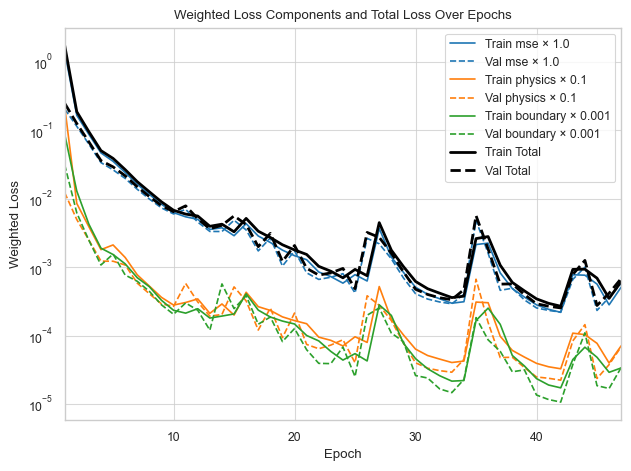

In [136]:
def plot_weighted_loss_components(train_acc, val_acc, save_as_pdf=False, filename='weighted_loss_components_phy'):
    """
    Plots training vs validation curves for each loss component (multiplicados por su peso),
    usando el mismo color para train/val y distinto estilo de línea.
    Permite guardar la figura como PDF en la carpeta 'figures' si save_as_pdf=True.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    epochs = list(range(1, len(train_acc['total']) + 1))
    weights = {
        'mse':       mse_weight,
        'physics':   physics_weight,
        'boundary':  boundary_weight
    }
    # Paleta de colores para cada componente
    color_map = {
        'mse':      '#1f77b4',  # azul
        'physics':  '#ff7f0e',  # naranja
        'boundary': '#2ca02c',  # verde
        'total':    'k'         # negro
    }
    # Componentes individuales multiplicados por su peso
    for name in ['mse', 'physics', 'boundary']:
        plt.plot(epochs, np.array(train_acc[name]) * weights[name],
                 label=f"Train {name} × {weights[name]}",
                 color=color_map[name], linestyle='-')
        plt.plot(epochs, np.array(val_acc[name]) * weights[name],
                 label=f"Val {name} × {weights[name]}",
                 color=color_map[name], linestyle='--')
    # Pérdida total
    plt.plot(epochs, train_acc['total'], color=color_map['total'], linewidth=2, label='Train Total', linestyle='-')
    plt.plot(epochs, val_acc['total'], color=color_map['total'], linewidth=2, label='Val Total', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Weighted Loss")
    plt.yscale("log")
    plt.title("Weighted Loss Components and Total Loss Over Epochs")
    plt.legend()
    plt.xlim(epochs[0], epochs[-1])  # Ajusta el eje x a los valores representados
    plt.tight_layout()
    if save_as_pdf:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{filename}.pdf', format='pdf')
    plt.show()

# Ejemplo de uso:
plot_weighted_loss_components(train_acc, val_acc, save_as_pdf=True, filename='weighted_loss_components_phy')

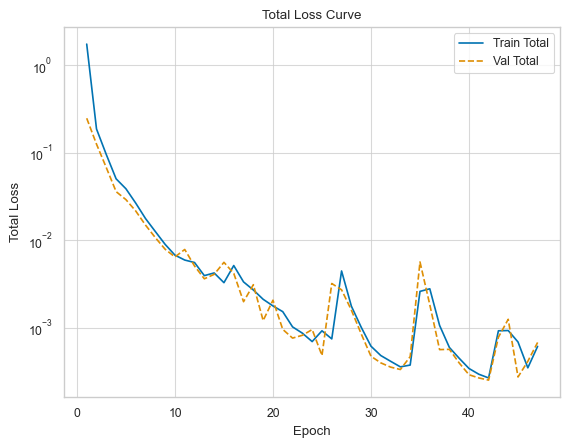

In [ ]:
def plot_total_loss_curve(train_acc, val_acc):
    """
    Grafica la pérdida total de entrenamiento y validación.
    """
    epochs = list(range(1, len(train_acc['total'])+1))
    plt.plot(epochs, train_acc['total'], label='Train Total')
    plt.yscale("log")  # Usar escala logarítmica para mejor visualización
    plt.plot(epochs, val_acc['total'], label='Val Total')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Total Loss Curve')
    plt.legend()
    plt.xlim(epochs[0], epochs[-1])  # Ajusta el eje x a los valores representados
    plt.show()

plot_total_loss_curve(train_acc, val_acc)

### Testing

Carga el mejor modelo entrenado y evalúa su rendimiento en el conjunto de test mediante una función `rollout` autoregresiva.

- La función `rollout` genera toda la secuencia de salida autoregresiva usando como entrada las condiciones de contorno (`bc_seq`) y la temperatura inicial (`T0`).
- Se evalúa la pérdida total del modelo sobre todas las muestras y también se calcula la pérdida por paso de tiempo.

Incluye impresión opcional de errores en pasos específicos para analizar cómo evoluciona el error en el tiempo.


In [55]:
# --- 1. Carga del mejor modelo ---
model_phy = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model_phy.load_state_dict(torch.load(model_path, map_location=device))
model_phy.eval()

# --- 2. Función de rollout autoregresivo puro ---
@torch.no_grad()
def rollout(model, bc_seq, T0):
    """
    Predicción autoregresiva completa.

    Args:
        model   : modelo PyTorch
        bc_seq  : tensor (B, T, 5, H, W) con canales de contorno ya en device
        T0      : tensor (B, 1, H, W) condición inicial ya en device

    Returns:
        preds   : tensor (B, T, 1, H, W) con predicciones autoregresivas
    """
    B, T, _, H, W = bc_seq.shape
    preds = []
    t_prev = T0
    hidden = None

    for t in range(T):
        x_t = torch.cat([bc_seq[:, t], t_prev], dim=1).unsqueeze(1)  # (B,1,6,H,W)
        pred_seq, hidden = model(x_t, hidden)
        t_prev = pred_seq[:, 0]
        preds.append(t_prev)

    return torch.stack(preds, dim=1)

# --- Test completo ---
test_losses = []
step_losses = torch.zeros(sequence_length, device=device)

model_phy.eval()
with torch.no_grad():
    for x_batch, y_batch, *_ in tqdm(test_loader_phy, desc="Testing"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        bc_seq = x_batch[:, :, :5]
        T0 = x_batch[:, 0, 5:6]

        y_pred = rollout(model_phy, bc_seq, T0)

        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        for t in range(y_pred.shape[1]):
            step_losses[t] += criterion(y_pred[:, t], y_batch[:, t]).item() * y_pred.size(0)

mean_test_loss = sum(test_losses) / len(test_losses)
step_losses = (step_losses / len(test_loader_phy.dataset)).cpu().numpy()

print(f"▶︎ Test Loss (secuencia completa): {mean_test_loss:.6f}")

for t_idx in [0, y_pred.shape[1]-1]:
    print(f"  Paso {t_idx+1:2d} Loss: {step_losses[t_idx]:.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\600055490.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_phy.load_state_dict(torch.load(model_path, map_lo

▶︎ Test Loss (secuencia completa): 0.000009
  Paso  1 Loss: 0.000003
  Paso 21 Loss: 0.000024


### Analyzing results

In [56]:
# time_sim = 50
# sequence_length = time_sim + 1

Define una función `predict_from_conditions(...)` que genera una predicción completa de temperatura dada una condición inicial y parámetros físicos del sistema (como temperaturas de interfaces y potencia de calentadores).

- Usa el método `create_input_from_values` del dataset para construir la entrada a partir de arrays.
- Realiza el `rollout` paso a paso utilizando el método `forward_step` del modelo.
- Devuelve una secuencia completa desnormalizada en formato `np.ndarray`.

Esta función es clave para usar el modelo en modo inferencia realista, fuera del flujo de entrenamiento.


In [ ]:
# def predict_from_conditions(Q_heaters: np.ndarray,
#                             T_interfaces: np.ndarray,
#                             T_env: float,
#                             sequence_length: int = 1001,
#                             T_seq_initial: np.ndarray = None,
#                             model=None,
#                             dataset=None,
#                             device=None) -> np.ndarray:
#     """
#     Genera una predicción completa de long. sequence_length a partir de:
#       - Q_heaters:        (4,)             np.ndarray
#       - T_interfaces:     (4,)             np.ndarray
#       - T_env:            scalar           float
#       - T_seq_initial:    (13,13)          np.ndarray (el mapa inicial)
#       - sequence_length:  número de pasos a predecir
#       - model:            tu PCB_ConvLSTM cargado y en .eval()
#       - dataset:          instancia de PCBDataset_convlstm con create_input_from_values
#       - device:           opcional, torch.device

#     Devuelve:
#       np.ndarray de forma (sequence_length, 13, 13) con la serie desnormalizada.
#     """

#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device
        
#     if T_seq_initial is None:
#         T_seq_initial = np.full((13, 13), 298.0)  # Mapa por defecto a 298 K

#     # 1) Primer input (1,1,6,13,13)
#     input0 = dataset.create_input_from_values(
#         Q_heaters, T_interfaces, T_env,
#         T_seq=np.expand_dims(T_seq_initial, 0),
#         sequence_length=sequence_length,
#         autorregress=True
#     ).to(device)

#     # 2) Prepara contornos y t_prev
#     # bc_static: (1, seq_len, 5, 13,13)
#     bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
#     # t_prev: (1,1,1,13,13)
#     t_prev = input0[:, :1, 5:6, :, :]

#     # 3) Roll-out autoregresivo
#     preds_norm = []
#     hidden = None
#     with torch.no_grad():
#         for t in range(sequence_length):
#             # concatenar por canal (dim=2)
#             x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
#             pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
#             t_prev = pred_t                                        # mantener shape
#             preds_norm.append(t_prev)

#     preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

#     # 4) Desnormalizar y to numpy
#     mean = dataset.T_outputs_mean.to(device)
#     std  = dataset.T_outputs_std.to(device)
#     preds_denorm = preds_norm * std + mean      # (1, T, 1, H, W)
#     preds_denorm = preds_denorm.squeeze(0).squeeze(1)  # (T, 13,13)
#     return preds_denorm.cpu().numpy()

Carga de nuevo el modelo desde el disco y lo pone en modo evaluación (`eval()`), para realizar predicciones sin modificar sus parámetros.

Esto es útil para preparar el modelo antes de realizar inferencias como las de la función anterior.


In [58]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\2658188333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(70, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

Define las posiciones de los nodos que se quieran estudiar, en el caso por defecto los heaters (`id_heaters`), como tuplas de coordenadas dentro de la malla 13x13.

In [59]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Define las condiciones físicas para el caso de prueba:

- `Q_heaters`: potencia aplicada por cada calentador.
- `T_interfaces`: temperaturas fijas en las interfaces térmicas.
- `T_env`: temperatura ambiente.
- `T_initial_map`: mapa de temperatura inicial uniforme, basado en `T_init`.

Estas variables se usarán como entrada en la simulación o para el modelo entrenado.


In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 300
T_initial_map = np.full((13, 13), T_init)

Ejecuta el caso de simulación real `PCB_case_2` con los parámetros definidos (en modo transitorio) para obtener la solución de referencia.

- `T`: contiene toda la evolución temporal.
- Se reestructura la salida en forma de malla `(T, 13, 13)`.
- Se convierte a `tensor` y se sube al dispositivo (`cpu` o `cuda`) para usarla en comparación o inferencia.

Esto proporciona la verdad de terreno contra la cual se comparará la predicción del modelo.


In [61]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)

Llama a la función `predict_from_conditions(...)` usando las condiciones definidas (`Q_heaters`, `T_interfaces`, `T_env`, `T_initial_map`) y genera la predicción de temperatura a lo largo del tiempo.

- Devuelve un array `(T, 13, 13)` con la evolución térmica.
- Se convierte a tensor y se envía al dispositivo para facilitar cálculos posteriores.

Este bloque representa el uso final del modelo entrenado para hacer una predicción completa.


In [63]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model_phy,
    dataset=dataset_phy,  # Usar el dataset de entrenamiento para crear inputs
    device=device
)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W)

print(T_pred.shape)  # (T, 13, 13)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])
(21, 13, 13)


Dibuja la evolución térmica en nodos seleccionados a lo largo del tiempo, comparando la **predicción del modelo (`T_pred`)** con la **solución de referencia (`T_true`)**.

El parámetro `together=True` indica que ambas curvas se mostrarán en la misma figura para facilitar la comparación.

Este paso permite evaluar visualmente la precisión del modelo.


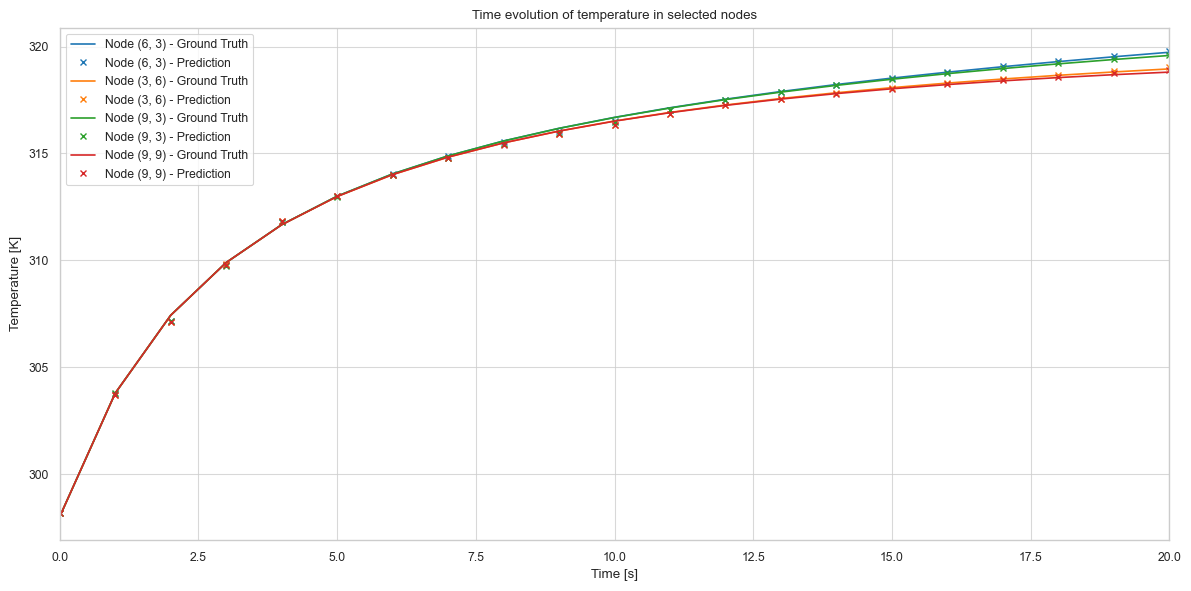

In [ ]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True, save_as_pdf=False, filename='nodes_evolution_phy')

Evalúa la precisión del modelo usando métricas basadas en un **umbral de error absoluto** (en Kelvin):

- `porcentaje_error_bajo_umbral`: calcula el porcentaje de valores predichos cuyo error es menor que el umbral especificado.
- `nodos_siempre_dentro_umbral`: determina el porcentaje de nodos que están por debajo del umbral en **todos los pasos de tiempo**.

Estas métricas permiten cuantificar de forma robusta la calidad de la predicción.


In [65]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 100.00%
Porcentaje de nodos buenos: 100.00%


Calcula y visualiza una **curva de precisión acumulada** en función del umbral de error:

- Evalúa qué porcentaje de nodos cumplen con el criterio de error para cada valor de umbral entre 0 y 25 K.
- Muestra una gráfica que permite analizar la sensibilidad del modelo al nivel de tolerancia de error.

Esta representación es útil para comparar distintos modelos o configuraciones.


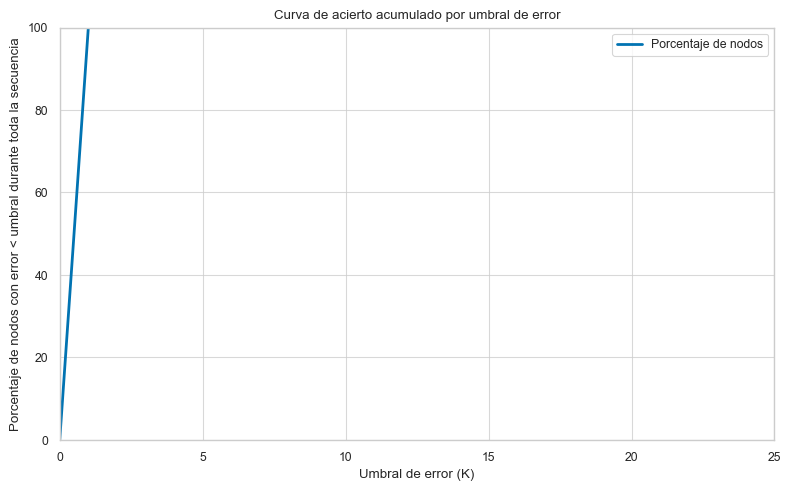

In [ ]:
umbrales = np.linspace(0, 5, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Grafica el **error absoluto medio (MAE)** por fotograma (paso temporal), comparando la predicción del modelo y la solución de referencia.

Esto permite observar cómo evoluciona el error del modelo a lo largo de la secuencia y detectar posibles derivas o acumulaciones de error en el tiempo.


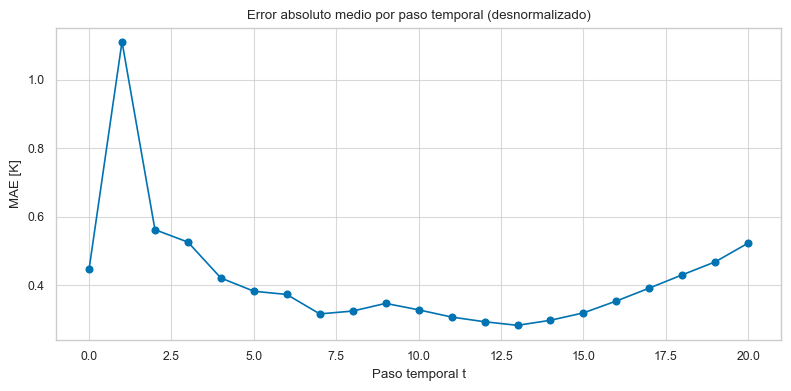

In [ ]:
plot_mae_per_frame(T_pred, T_true, dataset_phy, save_as_pdf=False, filename='mae_per_frame_phy')

Genera una figura con el **MAE por píxel** (nodo de la malla), calculado sobre toda la secuencia temporal.

Esto permite identificar qué zonas del PCB tienen mayor o menor error sistemático, y si existen patrones espaciales en el comportamiento del modelo.


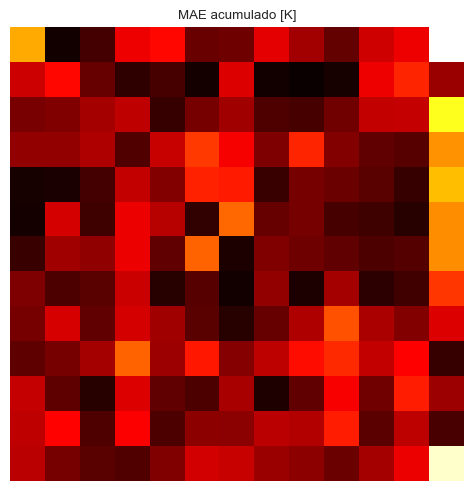

In [ ]:
plot_mae_per_pixel(T_pred, T_true, dataset_phy, save_as_pdf=True, filename='mae_per_pixel_phy')

Crea una animación en forma de **GIF comparativo** entre la predicción (`T_pred`) y la solución real (`T_true`) a lo largo del tiempo.

- Guarda el GIF en la carpeta `figures`.
- Lo muestra directamente en el notebook usando HTML.

Esta animación es muy útil para validar visualmente el desempeño dinámico del modelo.


In [ ]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='comparacion_phy')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Genera un **GIF que visualiza la evolución del error absoluto** entre la predicción y la realidad en cada paso temporal.

- Muestra cómo cambia el error con el tiempo.
- Útil para detectar acumulación de error, deriva o zonas problemáticas.

La animación se guarda y se muestra directamente en el notebook.


In [ ]:
ani = generar_gif_error_evolucion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='error_phy')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

## Comparison between models

Aquí se va a comparar los resultados obtenidos para ambos modelos (con y sin física).


### Hyperparameter summary


En primer lugar, se resumen los parámetros usados

In [110]:
print('Épocas máximas de entrenamiento:', epochs)
print('Tiempo simulado:', time_sim, 's', '(', sequence_length, 'pasos, con dt =', dt, 's)')
print()
print('Número de muestras de entrenamiento:', n_train)
print('Número de muestras de validación:', n_val)
print('Número de muestras de test:', n_test)
print('Batch size:', batch_size)
print()
print('Hiperparámetros del modelo:')
print('Número de canales de entrada:', input_channels)
print('Numero de capas ocultas:', num_layers)  
print('Dimensiones de las capas ocultas:', hidden_dims)
print('Tamaño del kernel:', kernel_size)
print()
print('Hiperparámetros de pérdida física:')
print(f"  MSE: {mse_weight}, Physics: {physics_weight}, Boundary: {boundary_weight}")
print()
print('Hiperparámetros de entrenamiento:')
print(f"  Learning Rate: {lr}, LR Decay: {lrdecay}, LR Decay Patience: {lrdecay_patience}")
print(f"  Early Stop Patience: {early_stop_patience}")
print()
print('Hiperparámetros de scheduled sampling:')
print(f"  p0: {p0}, p_min: {p_min}, Decay Epochs: {decay_epochs}")

Épocas máximas de entrenamiento: 1000
Tiempo simulado: 20 s ( 21 pasos, con dt = 1 s)

Número de muestras de entrenamiento: 2500
Número de muestras de validación: 200
Número de muestras de test: 20
Batch size: 256

Hiperparámetros del modelo:
Número de canales de entrada: 6
Numero de capas ocultas: 2
Dimensiones de las capas ocultas: [64, 64]
Tamaño del kernel: [(3, 3), (3, 3)]

Hiperparámetros de pérdida física:
  MSE: 1.0, Physics: 0.1, Boundary: 0.001

Hiperparámetros de entrenamiento:
  Learning Rate: 0.01, LR Decay: 0.1, LR Decay Patience: 10
  Early Stop Patience: 50

Hiperparámetros de scheduled sampling:
  p0: 1.0, p_min: 0.0, Decay Epochs: 200


### Load both models

Ubicar el path de ambos

In [111]:
# Puedes cambiar esta ruta a mano si quieres usar una carpeta concreta
# Si dejas None, guardará en MODELS_PATH/ConvLSTM_6ch/stateful_O2O
custom_model_dir = None  # por ejemplo: Path("~/experimentos/cheops_v3").expanduser()

# ----------- Configurar ruta de guardado -----------
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

if custom_model_dir is None:
    model_dir = MODELS_PATH / "ConvLSTM_6ch" / "stateful_O2O"
else:
    model_dir = Path(custom_model_dir).resolve()

model_dir.mkdir(parents=True, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = model_dir / filename
json_path = model_path.with_suffix(".json")

filename_phy = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_bs{batch_size}_h{layer_string}_k{kernel_string}_mse{mse_weight}_phy{physics_weight}_bnd{boundary_weight}.pth"
model_path_phy = model_dir / filename_phy
json_path_phy = model_path_phy.with_suffix(".json")

Cargar el modelo sin física

In [112]:
model = PCB_ConvLSTM(input_channels=input_channels,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\1669701267.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(70, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

Cargar el modelo con física

In [113]:
model_phy = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model_phy.load_state_dict(torch.load(model_path_phy, map_location=device))
model_phy.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_9356\3818295601.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_phy.load_state_dict(torch.load(model_path_phy, m

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(70, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

### Prediction of one case

Boundary condition selection

In [114]:
T_interfaces = np.array([290, 290, 290, 290])
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_env = 250

Solver solution

In [115]:
T_true, *_ = PCB_case_2(solver='transient', display=False, time=time_sim, dt=dt, T_init=T_init, Q_heaters=Q_heaters, T_interfaces=T_interfaces, Tenv=T_env)
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side)  # reshaping the data grid-shape

Non-physics model predition

In [116]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model,
    dataset=dataset,
    device=device
)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])


Physics model prediction

In [117]:
T_pred_phy = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length,
    model=model_phy,
    dataset=dataset_phy,
    device=device
)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])


Representación de las soluciones para nodos determinados

In [118]:
id_nodes = [(6,3)] 

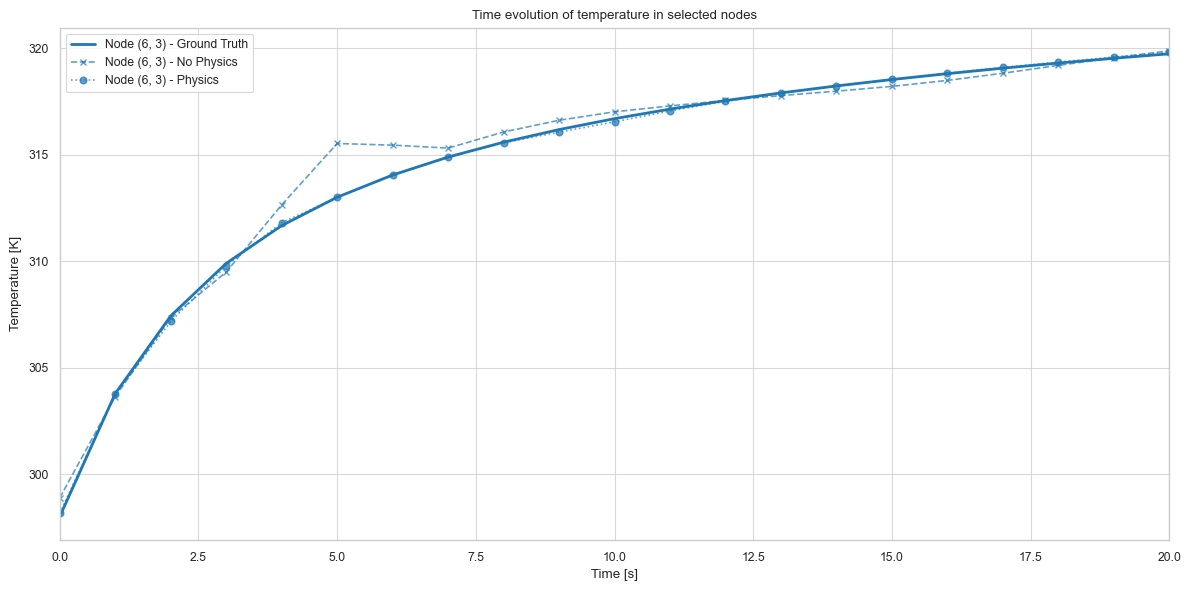

In [ ]:
plot_nodes_evolution_3way(T_true, T_pred, T_pred_phy, id_nodes, together=True, save_as_pdf=True, filename='nodes_evolution_3way')

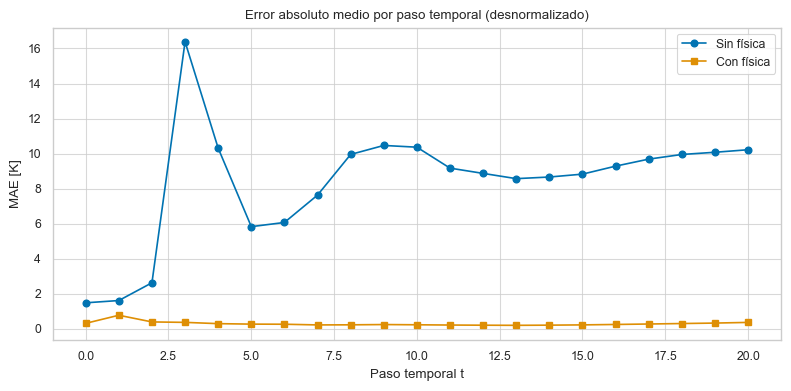

In [ ]:
plot_mae_per_frame_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_frame_2way')

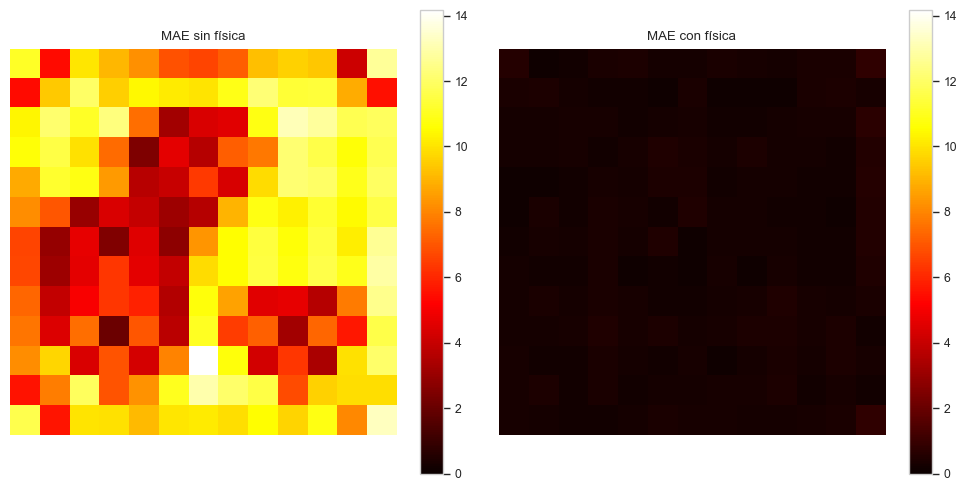

In [ ]:
plot_mae_per_pixel_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_pixel_2way')

In [ ]:
ani = generar_gif_pcb_comparacion_3way(T_pred, T_pred_phy, T_true, dt=1, nombre_archivo="comparacion_2modelos", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparacion_3modelos.gif
Gif guardado.


In [123]:
ani = generar_gif_error_evolucion_2way(T_pred, T_pred_phy, T_true, dt=1, nombre_archivo="error_2modelos", guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\error_2modelos.gif
Gif guardado.


### Prediction of a longer sequence than trained

Se va a probar a ver como responden ambos modelos a la predicción de una secuencia más larga que la planteada para el entrenamiento

In [ ]:
time_sim_long = 100  # Simulación más larga para ver diferencias
sequence_length_long = time_sim_long + 1

print(f"Modelo entrenado para un tiempo de simulación de {time_sim} s")
print(f"Predicción con modelo original (sin física) para {time_sim_long} s")

Modelo entrenado para un tiempo de simulación de 20 s
Predicción con modelo original (sin física) para 1000 s


Solver solution

In [125]:
T_true, *_ = PCB_case_2(solver='transient', display=False, time=time_sim_long, dt=dt, T_init=T_init, Q_heaters=Q_heaters, T_interfaces=T_interfaces, Tenv=T_env)
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side)  # reshaping the data grid-shape

Non-physics model predition

In [126]:
T_pred = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length_long,
    model=model,
    dataset=dataset,
    device=device
)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])


Physics model prediction

In [127]:
T_pred_phy = predict_from_conditions(
    Q_heaters=Q_heaters,
    T_interfaces=T_interfaces,
    T_env=T_env,
    sequence_length=sequence_length_long,
    model=model_phy,
    dataset=dataset_phy,
    device=device
)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])


Representación de las soluciones para nodos determinados

In [128]:
id_nodes = [(6,3)] 

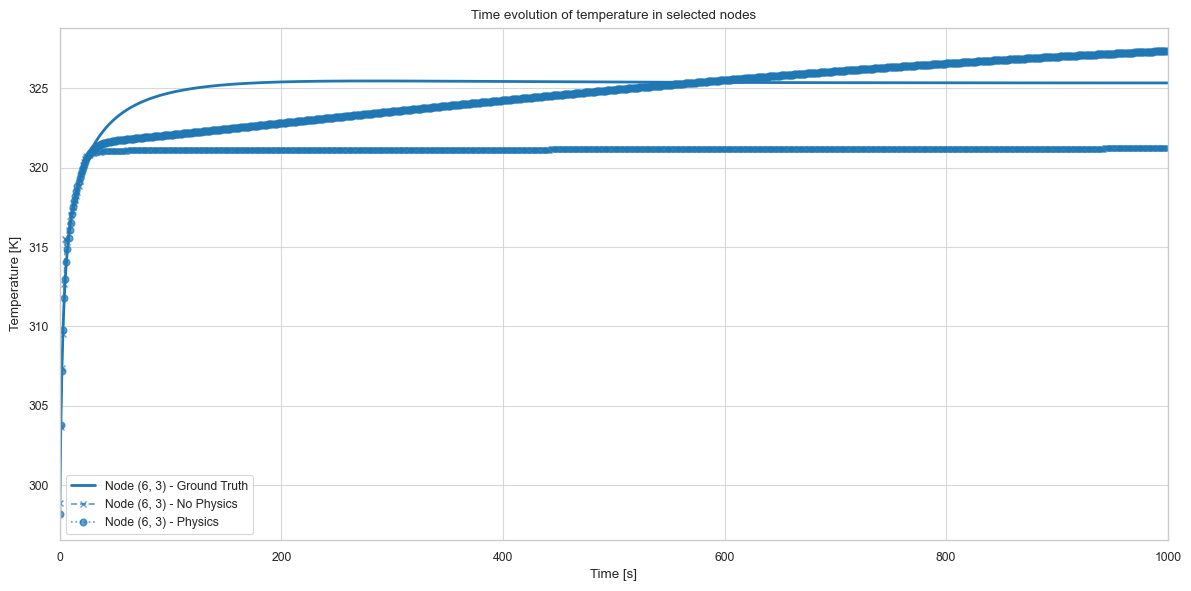

In [ ]:
plot_nodes_evolution_3way(T_true, T_pred, T_pred_phy, id_nodes, together=True, save_as_pdf=True, filename='nodes_evolution_3way_prop')

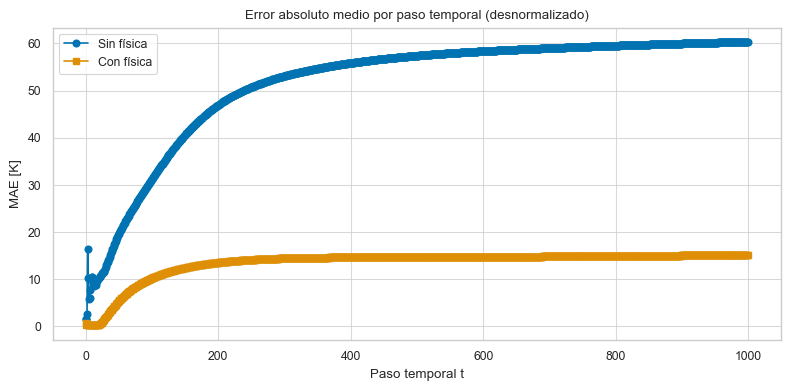

In [130]:
plot_mae_per_frame_2way(T_true, T_pred, T_pred_phy, dataset=dataset)

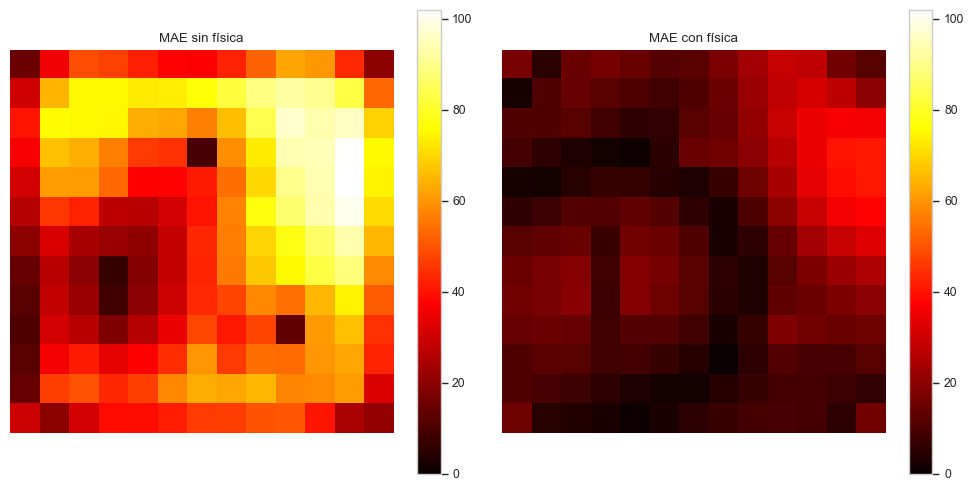

In [ ]:
plot_mae_per_pixel_2way(T_true, T_pred, T_pred_phy, dataset=dataset, save_as_pdf=True, filename='mae_per_pixel_2way_propag')

In [ ]:
ani = generar_gif_pcb_comparacion_3way(T_pred, T_pred_phy, T_true, dt=1, nombre_archivo="comparacion_2modelos_propag", guardar_en_figures=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparacion_3modelos.gif
Gif guardado.


In [134]:
ani = generar_gif_error_evolucion_2way(T_pred, T_pred_phy, T_true, dt=1, nombre_archivo="error_2modelos_propag", guardar_en_figures=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\error_2modelos.gif
Gif guardado.
